# Model of collective behavior using bio-plausible visual cues
### Diego Castro, Franck Ruﬀier and Christophe Eloy
This is an example of the model described by the paper "[Model of collective behavior using bio-plausible visual cues](https://arxiv.org/abs/2305.06733)".
Within this notebook you will find the model implementation, simulation handling and resulting metric graph for a set of gains $[k_\odot,k_\parallel]$. Unlike the [full version](https://src.koda.cnrs.fr/diegoCASTRO/flocking-by-eye) of the model implementation this notebook will not save any data, will **only** display:
    -The initial condition of the flock
    -The final state of the flock
    -The whole metric plot for <span style="color:blue">Polarization</span>, <span style="color:red">Milling</span> and <span style="color:green">Standard deviation</span>.


## Implemented Model
This notebook implements the following model:
$$ \dot{\boldsymbol{x}}_i  =  U \boldsymbol{e}_i $$

$$ \dot \theta_i  =  k_\odot \, \omega_\odot + k_{\parallel,\phi} \, \omega_{\parallel,\phi}+k_{\parallel,r} \,\omega_{\parallel,r} + k_\eta \, \eta $$
Where:

 $$ \omega_\odot = \frac
    {\sum_k 2 A(\Delta\varphi_k) \left(
        1 + \epsilon\cos\varphi_k\cos\Delta\varphi_k
    \right)\sin\Delta\varphi_k \sin\varphi_k}
    {\sum_k  2 \left(
        1 + \epsilon\cos\varphi_k\cos\Delta\varphi_k
    \right) \sin\Delta\varphi_k  } $$
$$ A(\Delta\varphi_k)=
    \begin{cases}
        1 & \text{if } \Delta\varphi_k \, <\pi/2\\
        -1 & \text{ if } \Delta\varphi_k \, \geq \pi/2
    \end{cases} $$
$$ \omega_{\parallel,\phi}  \approx \frac
     {\sum_k V_\phi (1 + \epsilon\cos\varphi_k) \cos\varphi_k}
     {\sum_k|V_\phi|(1+\epsilon\cos\varphi_k)} $$
$$ \omega_{\parallel,r}  \approx  \frac
     {\sum_k V_r (1 + \epsilon\cos\varphi_k) \sin\varphi_k}
     {\sum_k |V_r| (1 + \epsilon\cos\varphi_k)}$$
$V_r$ and $V_\phi$ are the relative velocities components (radial and azimuthal respectively) derived from the Optic Flow.

## Library Prerequisites
This notebook uses:
[ ] numpy
[ ] colorsys
[ ] matplotlib
[ ] logging

In [1]:
import numpy as np
from colorsys import hsv_to_rgb
from numpy.linalg import norm as norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea,  VPacker
import logging
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y/%m/%d %H:%M:%S ', level=logging.CRITICAL)

## Notebook Independent Constant Variables
The model in this notebook have the following variables related to the flocking model:
-**N**= Number of individuals belonging to the flock.
-**a**= Radius of all individuals.
-**$k_\eta$**= Gain of the Wiener process representing rotational noise.
-**U**= Linear speed for all individuals (*this is set as a factor of a/$k_\eta$*).
-**$k_\odot$**= Gain of the attraction component of the model.
-**$k_{\parallel,\phi}$**= Gain of the alignment component of the model, azimuthal part.
-**$k_{\parallel,r}$**= Gain of the alignment component of the model, radial part.
*These gain will be aggregated to a single array* gains=$[k_\odot,k_{\parallel,\phi},k_{\parallel,r},k_\eta]$
-$\delta t$ Time step of the simulation.
-$\epsilon$ Blind spot of the visual field effect ($\epsilon$=0 perfect view)

In [2]:
class Global_static_Variables:
    def __init__(self, _N, _RADIUS, _DT, _EPSILON, _GAINS, _U):
        # Model Variables
        self._N = _N
        self._RADIUS = _RADIUS
        self._DT = _DT
        self._EPSILON = _EPSILON
        self._U = _U * (_RADIUS/_GAINS[-1])
        self._GAINS = np.array(_GAINS)[np.newaxis, :]
        self.NewDts = 0
    def __str__(self):
        out = " V=%0.4f N=%04d dt=%0.4f %0.2f=%0.3f-%0.3f-%0.3f" % (self._U ,self._N, self._DT, self._EPSILON,
                                                                            self._GAINS[0][0], self._GAINS[0][1],
                                                                            self._GAINS[0][2])
        return out

## Flock Related functions
These set of functions simulate the flock environment. All theres are the functions that better dynamics, kinematics, hardware in the loop, real physics simulators could replace.
#### updated_metric=add_metric(metric,value)
Miscelaneous function to add a value to a numpy array at the beginning and remove the last item on the array.
-*metric* the numpy array
-*value* the value to add
-**updated_metric** the new numpy array with the added value at the beginning

In [3]:
#Flock Functions
def add_metric(metric,value):
    updated_metric=np.roll(metric,1,axis=0)
    updated_metric[0,:,:]=value
    return updated_metric

#### Visual_Fields=Flock_Update_Visual_Field(Flock,Flock_Colors,Constants)
Function that takes the flock numpy array
with the coordinates and heading of all the flock and returns a dictionary with each individual visual field centered at their heading
- * Flock * = [N x 3] numpy array with the x, y coordinates and the heading for all the individuals of the flock
- * Flock_Colors * = [N x 1] array with the HEX color values for the flock
- * Constants * = [Global_static_Variables] All the simulation constants variables
- ** Flock_visual_field ** = [N x k x 2] Dictionary with the all the visual fields for the current $\delta t$, rising edge and falling edge of each shade that an individual sees for all the flock.

In [4]:
def Flock_Update_Visual_Field(Flock, Flock_Colors, Constants):
    Flock_visual_field = {}
    for ind, name in zip(Flock, Flock_Colors):
        relative_pos = Flock[:, :-1] - ind[:-1]
        theta = np.arctan2(relative_pos[:, 1], relative_pos[:, 0]) - ind[-1]
        theta = np.mod(theta, 2 * np.pi)
        if any(np.isnan(theta)):
            theta = np.delete(theta, np.isnan(theta))
        r = np.hypot(relative_pos[:, 0], relative_pos[:, 1])
        del_val = np.where(r <= 2 * Constants._RADIUS)
        theta = np.delete(theta, del_val)
        r = np.delete(r, del_val)
        phi = np.arcsin(Constants._RADIUS / r)
        angles_start = theta - phi
        angles_end = theta + phi
        pi_reflection = np.where(angles_start <= 0)
        angles_start[pi_reflection] = angles_start[pi_reflection] + 2 * np.pi
        sorting_order = np.argsort(angles_start, kind='heapsort')
        angles_start = angles_start[sorting_order]
        angles_end = angles_end[sorting_order]
        Vt = []
        if len(angles_start) > 0:
            Vt.append([angles_start[0], angles_end[0]])
            for angle_start, angle_end in zip(angles_start[1:], angles_end[1:]):
                Curr_start = Vt[-1][0]
                Curr_end = Vt[-1][1]
                if angle_start < Curr_end:
                    if Curr_end < angle_end:
                        Vt[-1] = [Curr_start, angle_end]
                    else:
                        pass
                else:
                    Vt.append([angle_start, angle_end])
            if Vt[-1][1] < np.pi and Vt[-1][0] > np.pi:
                Vt[-1][1] += 2 * np.pi
            if len(Vt) > 3:
                if Vt[-2][1] - 2 * np.pi >= Vt[0][0]:
                    Vt[-2] = [Vt[-2][0], Vt[0][1] + 2 * np.pi]
                    Vt.pop(0)
            Flock_visual_field[name] = np.array(Vt)
        else:
            Flock_visual_field[name] = np.zeros([2, 2])
    return Flock_visual_field

#### [Flock,Flock_Colors,Flock_Omegas]=Flock_Create(Constants)
Based on the Constants for the simulation this function returns:
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**Flock** = [N x 3] numpy array with the x,y coordinates and the heading for all the individuals of the flock
-**Flock_Colors** = [N] array with the HEX color values for the flock
-**Flock_Omegas** = [N x 3] numpy array of zeros for the evaluation of the model


In [5]:
def Flock_Create(Constants):
    Flock_Colors=[]
    Flock=np.zeros([Constants._N,3])
    Flock[:,-1]=(np.random.random(Constants._N))*2*np.pi
    Flock_Omegas=np.zeros([Constants._N,3])
    ##Position
    Flock[:,:-1]=np.random.random((Constants._N,2))*40*np.sqrt(Constants._N*Constants._RADIUS)
    for i in range(Constants._N):
        for j in range(Constants._N):
            if i!=j:
                relative_pos=Flock[i,:-1]-Flock[j,:-1]
                r=np.hypot(relative_pos[0],relative_pos[1])
                while r < (Constants._RADIUS + Constants._RADIUS * 0.1) * 2:
                    test = np.random.random(1)
                    if test < 0.25:
                        Flock[j,0] += 2 * Constants._RADIUS
                    if 0.25 <= test < 0.5:
                        Flock[j,0] -= 2 * Constants._RADIUS
                    if 0.5 <= test < 0.75:
                        Flock[j,1] -= 2 * Constants._RADIUS
                    if test >= 0.75:
                        Flock[j,1] += 2 * Constants._RADIUS
                    relative_pos=Flock[i,:-1]-Flock[j,:-1]
                    r=np.hypot(relative_pos[0],relative_pos[1])
        ##Colors
        h=200+(200+33*i)%80
        if i%20==0:
            h = 120
        s=1-(i%2)*0.3
        v=1-(i%25)*0.015
        rgb = hsv_to_rgb((h)%360/360, s,v)
        color = '#{:02x}{:02x}{:02x}'.format(*[int(255 * u) for u in rgb])
        j=0
        while color in Flock_Colors or color=='#ffffff':
            h=(h+j)%360
            v=1-((i+j)%2)*0.4
            s=1-((i+j)%25)*0.02
            rgb = hsv_to_rgb(h/360,v,s)
            j+=1
            color = '#{:02x}{:02x}{:02x}'.format(*[int(255 * u) for u in rgb])
        Flock_Colors.append(color)
    return [Flock,Flock_Colors,Flock_Omegas]

#### Updated_Flock = Flock_Update(Flock,Flock_Omegas,Constants)
This function updates the coordinates and the heading of the individuals of the flock to a new $\delta t$
-*Flock*= [N x 3] Numpy array with the current coordinates and heading for the flock
-*Flock_Omegas*= [N x 3] Numpy array with the current model omega output for the current $\delta t$
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**Updated_Flock** = [N x 3] Numpy array with the new coordinates and heading for the flock

In [6]:
def Flock_Update(Flock,Flock_Omegas,Constants):
    Updated_Flock = Flock
    Directions=np.mod(Flock[:,-1] +Constants._DT/20 *np.sum(Constants._GAINS*Flock_Omegas,axis=1),2*np.pi)
    Updated_Flock[:,:-1]=Flock[:,:-1]+np.append(np.cos(Directions[:,np.newaxis]),np.sin(Directions[:,np.newaxis]),axis=1)*Constants._U*Constants._DT
    Updated_Flock[:,-1]=Directions
    return Updated_Flock

#### Omega=Flock_Calculate_Omegas(Flock,Constants)
-*Flock*= [N x 3] Numpy array with the current coordinates and heading for the flock
-*Constants* = [Global_static_Variables] All the simulation constants variables.
-**Omega**= [N x 3] Numpy array with the recently calculated model omega output for the current $\delta t$.

In [7]:
def Flock_Calculate_Omegas(Flock,Constants):
    Omega=np.zeros([Constants._N,3])
    i=0
    for ind in Flock:
        Flock_without=Flock[np.unique(np.where(Flock!=ind))]
        Omega[i,0]=Model_Attraction(Flock_without,ind,Constants)
        Omega[i,1]=Model_Alignment(Flock_without,ind,Constants)
        Omega[i,2]=Weiner_Process(Constants)
        i+=1
    return Omega

 ## Individual Functions

#### Attraction_Omega=Model_Attraction(Flock,ind,Constants)
Implementation of:
$$ \omega_\odot = \frac{\sum_j  \frac{ A(\|x_i-x_j\|)\sin(\varphi_j)(1 + \epsilon\cos\varphi_j)}{\|x_i-x_j\|} }{\sum_j  \|\frac{ (1 + \epsilon\cos\varphi_j)}{\|x_i-x_j\|}\|} $$
-*Flock_without*= [N-1 x 3] Numpy array with the current coordinates and heading for the flock without the i-th individual
-*ind*= [3 x 1] Numpy array of the current coordinates and heading for the i-th individual
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**Attraction_Omega**= [float] result of the distance model $ \omega_\odot$.

In [8]:
#Model Implementation
def  Model_Attraction(Flock_without,ind,Constants):
    RelativePos=Flock_without[:,:-1]-ind[:-1]
    Angle=np.arctan2(RelativePos[:,1],RelativePos[:,0])-ind[-1]
    Distance=norm(RelativePos,axis=1)
    Att=np.sin(Angle)*Model_Repulsion(Distance,Constants)*(1+Constants._EPSILON*np.cos(Angle))/Distance
    aux=np.abs(Model_Repulsion(Distance,Constants)*(1+Constants._EPSILON*np.cos(Angle))/Distance)
    Attraction_Omega=float(np.sum(Att)/np.sum(aux))
    return Attraction_Omega

#### A=Model_Repulsion(Distance)
Implementation of:
$$ A(R)=
    \begin{cases}
        -1 & \text{if } R \, <a\\
        1 & \text{ if } R \, \geq a
    \end{cases} $$
-*Distance*= [N-1 x 1] Numpy array of all the distances between i-th individual and the rest of the flock
-**A**= [[N-1 x 1] Numpy array result of the model $ A(R)$.

In [9]:
def Model_Repulsion(Distance,Constants):
    A=Distance
    attract=np.where(Distance>=Constants._RADIUS)
    repel=np.where(Distance<Constants._RADIUS)
    A[repel]=-1
    A[attract]=1
    return A

#### Alignment_Omega=Model_Alignment_Phi(Flock_without,ind,Constants)
Implementation of:
$$ \omega_{\parallel}  =
     \frac{\sum_j (e_i \times e_j) (1 + \epsilon\cos\varphi_k)}{  \sum_j \left | (1 + \epsilon\cos\varphi_k) \right |} $$
-*Flock_without*= [L x 1] Numpy array of all the middle retinal positions of the shades that generate V_phi seen by the i-th individual
-*ind* = [L x 1] Numpy array of the resulting OpticFlow azimuthal component that approximates the relative velocity seen on the visual field of the i-th individual.
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**Attraction_Omega**= [float] result of the model $ \omega_{\parallel,\phi}$.

In [10]:
def  Model_Alignment(Flock_without,ind,Constants):
    ei=np.array([np.cos(ind[-1]),np.sin(ind[-1])])
    ej=np.array([np.cos(Flock_without[:,-1]),np.sin(Flock_without[:,-1])]).transpose()
    RelativePos=Flock_without[:,:-1]-ind[:-1]
    Distance=norm(RelativePos)
    Angle=np.arctan2(RelativePos[:,1],RelativePos[:,0])-ind[-1]
    Alignment_Omega=np.cross(np.full(ej.shape,ei),ej)*(1+Constants._EPSILON*np.cos(Angle))/Distance
    aux=np.abs((1+Constants._EPSILON*np.cos(Angle))/Distance)
    Alignment_Omega=np.sum(Alignment_Omega)/np.sum(aux)
    return Alignment_Omega


#### Weiner_Omega=Weiner_Process(Constants)
Implementation of $\eta$
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**Weiner_Omega**=[float] result of the model $\eta$

In [11]:
def Weiner_Process(Constants):
    Weiner_Omega=np.random.normal(loc=0, scale=1/np.sqrt(Constants._DT))
    return Weiner_Omega

## Flock Metric Functions
These are functions that implement the metrics used to describe any flock behaviour as a whole.
#### P=Flock_Calculate_P(Flock_Direction,Constants)
Implementation of:
$$ P =\| \overline{\boldsymbol{e}_i}\|$$
-**Flock_Direction** = [N x 1] numpy array with  the heading for all the individuals of the flock
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**P**= [float] metric result

In [12]:
#Flock Metric Functions
def Flock_Calculate_P(Flock_Direction,Constants):
    eix=np.cos(Flock_Direction)
    eiy=np.sin(Flock_Direction)
    P=norm([np.sum(eix),np.sum(eiy)])
    P=P/Constants._N
    return P

#### [Center,Dir]=Flock_Calculate_Center(Flock)
Calculate the centre  and the heading of the flock
-*Flock* = [N x 3] numpy array with the x,y coordinates and the heading for all the individuals of the flock
-**Dir** = [float] heading of the flock
-**Center**= x,y coordinate of the weighted center of the flock

In [13]:
def Flock_Calculate_Center(Flock):
    Center=np.mean(Flock[:,:-1],axis=0)
    eix=np.cos(Flock[:,-1])
    eiy=np.sin(Flock[:,-1])
    fx=np.mean(eix)
    fy=np.mean(eiy)
    Dir=np.mod(np.arctan2(fy,fx),2*np.pi)
    return [Center,Dir]

#### M=Flock_Calculate_M(Flock,Center)
Implementation of:
$$M = \| \overline{\boldsymbol{y}_i \times \boldsymbol{e}_i} \| $$
$\boldsymbol{y}_i= (\boldsymbol{x}_i- \overline{ \boldsymbol{x}_i})/\|\boldsymbol{x}_i- \overline{ \boldsymbol{x}_i}\|$

-*Center*=[2 x 1] x,y coordinate of the center of the flock
-*Flock* = [N x 3] numpy array with the x,y coordinates and the heading for all the individuals of the flock
-**M**= [float] Result of the metric

In [14]:
def Flock_Calculate_M(Flock,Center):
    vec_cent_2_ind=Flock[:,:-1]-Center
    eix=np.cos(Flock[:,-1])
    eiy=np.sin(Flock[:,-1])
    dir_vec=np.concatenate((eix[:,np.newaxis],eiy[:,np.newaxis]),axis=1)
    all_M=np.cross(vec_cent_2_ind,dir_vec)/norm(vec_cent_2_ind,axis=1)
    M=np.abs(np.mean(all_M))
    return M

#### S = Flock_Calculate_S(Flock_Position,Center,Constants)
implementation of:
$$S = \left(\overline{\|\boldsymbol{x}_i- \overline{ \boldsymbol{x}_i}\|^2} / a^2\right)^{1/2}$$
-*Flock_Position* = [N x 3] numpy array with the x,y coordinates and the heading for all the individuals of the flock
-*Center*=[2 x 1] x,y coordinate of the center of the flock
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**S**=[float] metric result

In [15]:
def Flock_Calculate_S(Flock_Position,Center,Constants):
    S=np.sqrt(np.mean(np.square(norm(Flock_Position-Center,axis=1)))/(Constants._RADIUS**2))
    return S

#### H = Flock_Calculate_S(Flock_visual_field,Constants)
implementation of:
$$H=\frac{\sum_i{\sum_k \frac{\Delta \phi_{i,k}}{2\pi}}}{N}$$
-*Flock_Visual_Fields* = [N x k x 2] Dictionary with the visual field for the current $\delta t$, rising edge and falling edge of each shade that an individual sees.
-*Constants* = [Global_static_Variables] All the simulation constants variables
-**H**=[float] metric result

In [16]:
def Flock_Calculate_H(Flock_visual_field,Constants):
    Flock_H=np.zeros(Constants._N)
    for ind,key in enumerate(Flock_visual_field):
        Flock_H[ind]=np.sum(Flock_visual_field[key][:,1]-Flock_visual_field[key][:,0])/(2*np.pi)
    H=np.mean(Flock_H)
    return H

In [18]:
_N=50
_RADIUS=5
_DT=0.1
_U=2
Kodot=3
Kparallel=1
Keta=1
_EPSILON=1
_GAINS= [Kodot,Kparallel,Keta]
Constants=Global_static_Variables(_N, _RADIUS, _DT, _EPSILON, _GAINS, _U)

In [19]:
[Flock,Flock_Colors,Flock_Omegas]=Flock_Create(Constants)
Flock=np.array(Flock)
InitialFlock=Flock
Flock_Snapshots=Flock

We set some minimum length requirements, Metric array and position history.

In [20]:
_MIN_TIME=2000 #time steps
_HISTORY=_MIN_TIME//10 #time steps
Flock_History=add_metric(np.zeros([_HISTORY,_N,3]),Flock)

_LOOP_COUNTER=0
Icontinue=True
iterations=_MIN_TIME

[Center,_]=Flock_Calculate_Center(Flock)
Metrics=np.array([Flock_Calculate_P(Flock[:,-1],Constants),
                  Flock_Calculate_M(Flock,Center),
                  Flock_Calculate_S(Flock[:,:-1],Center,Constants)])
Flock_Omegas=np.zeros([_N,3])

## Plot of initial condition

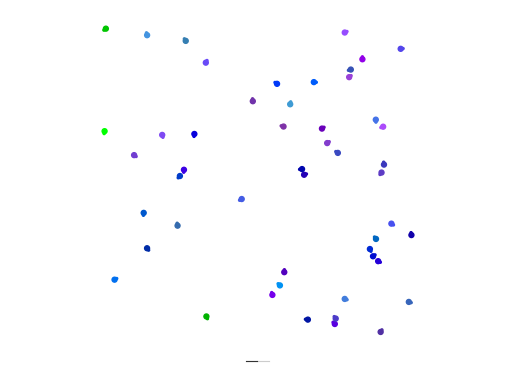

In [21]:
fig = plt.figure()
Canvas = plt.subplot()
for ind,ind_color, in zip(InitialFlock,Flock_Colors):
    ind_dir=ind[-1]
    ind_circle = plt.Circle((ind[0], ind[1]),radius=Constants._RADIUS, color=ind_color, alpha=1)
    Canvas.add_patch(ind_circle)
    ind_circle = plt.Circle((ind[0]+Constants._RADIUS*np.cos(ind_dir), ind[1]+Constants._RADIUS*np.sin(ind_dir)),radius=Constants._RADIUS//2, color=ind_color, alpha=1)
    Canvas.add_patch(ind_circle)
    del(ind_circle)
Canvas.axis('off')
[xm,xM,ym,yM]=Canvas.axis('equal')
sc2=plt.Rectangle(((xm+xM)/2-5*Constants._RADIUS, ym-5*Constants._RADIUS), 5*Constants._RADIUS, Constants._RADIUS/3, linewidth=0.1, color='0.2')
sc1=plt.Rectangle(((xm+xM)/2, ym-5*Constants._RADIUS), 5*Constants._RADIUS,  Constants._RADIUS/3, linewidth=0.1, color='0.8')
Canvas.add_patch(sc1)
Canvas.add_patch(sc2)
Canvas.axis('equal')
plt.show()

In [22]:
logging.critical("Simulation of: "+str(Constants))
while Icontinue:
    for i in range(iterations):
        #Move
        Flock=Flock_Update(Flock,Flock_Omegas,Constants)
        logging.debug('Moving')
        #calculate
        Flock_Omegas=Flock_Calculate_Omegas(Flock,Constants)
        logging.debug('Algorithm')
        #Metrics
        [Center,_]=Flock_Calculate_Center(Flock)
        dtMetrics=np.array([Flock_Calculate_P(Flock[:,-1],Constants),
                  Flock_Calculate_M(Flock,Center),
                  Flock_Calculate_S(Flock[:,:-1],Center,Constants)])
        logging.debug('Metrics')
        if len(Metrics.shape)==1:
            Metrics=np.array([Metrics,dtMetrics])
        else:
            Metrics=np.append(Metrics,[dtMetrics],axis=0)
        Flock_History=add_metric(Flock_History,Flock)
        if i%(_HISTORY)==_HISTORY-1:
            if len(Flock_Snapshots.shape)==2:
                Flock_Snapshots=np.append([Flock_Snapshots],[Flock],axis=0)
            else:
                Flock_Snapshots=np.append(Flock_Snapshots,[Flock],axis=0)
    _LOOP_COUNTER+=1
    logging.critical(str(iterations) +' dt completed')
    Perc_Variance=(np.max(Metrics[-_HISTORY:,:],axis=0)-np.min(Metrics[-_HISTORY:,:],axis=0))/np.mean(Metrics[-_HISTORY:,:],axis=0)
    logging.critical("Current Pseudo-Variance: "+str(Perc_Variance))
    logging.critical("Current Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
    if (Perc_Variance>1/np.sqrt(Constants._DT)/100).any():
        iterations=_HISTORY
    else:
        iterations=-1
        Icontinue=False
    if _LOOP_COUNTER>30 and np.sum((Perc_Variance<1/np.sqrt(Constants._DT)/100)*1)>=2:
        iterations=0
        Icontinue=False
    if len(Metrics) >= 6*_MIN_TIME:
        iterations=-2
        Icontinue=False
    if Icontinue:
        logging.warning("Yet to Converge... Current Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
logging.critical("Finishing... Final Variance: "+str(Perc_Variance)+ " Target: "+str(2/np.sqrt(Constants._DT)/100))
if iterations==-1:
    logging.critical("Successful "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
elif iterations==0:
    logging.critical("One Metric unstable "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
elif iterations==-2:
    logging.critical("Too Long not stable "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
else:
    logging.critical("MaxSize "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))

2023/06/27 22:01:42  Simulation of:  V=10.0000 N=0050 dt=0.1000 1.00=3.000-1.000-1.000
2023/06/27 22:01:49  2000 dt completed
2023/06/27 22:01:49  Current Pseudo-Variance: [0.40345524 0.2161214  0.3977197 ]
2023/06/27 22:01:49  Current Metrics: [ 0.52938441  0.45625473 38.08292928]
2023/06/27 22:01:49  200 dt completed
2023/06/27 22:01:49  Current Pseudo-Variance: [0.1554384  0.16775663 0.39232748]
2023/06/27 22:01:49  Current Metrics: [ 0.39832078  0.45803651 23.97758707]
2023/06/27 22:01:50  200 dt completed
2023/06/27 22:01:50  Current Pseudo-Variance: [0.34794344 1.98575527 0.03559286]
2023/06/27 22:01:50  Current Metrics: [ 0.56311428  0.21324641 20.67386468]
2023/06/27 22:01:51  200 dt completed
2023/06/27 22:01:51  Current Pseudo-Variance: [0.17725538 1.05197461 0.07585331]
2023/06/27 22:01:51  Current Metrics: [ 0.57671612  0.36149049 19.29814809]
2023/06/27 22:01:51  200 dt completed
2023/06/27 22:01:51  Current Pseudo-Variance: [0.25242063 1.51365525 0.12119618]
2023/06/27 22

In [23]:
fig = plt.figure()
Canvas = plt.subplot()
for k in range(len(Flock_History)):
    k_coords=Flock_History[k,:,:-1]
    if not (np.mean(k_coords)==0):
        pass
        for color,Pos in zip(Flock_Colors,k_coords):
            if k==0:
                pass
            else:
                ind_circle = plt.Circle((Pos[0], Pos[1]),radius=Constants._RADIUS/10, color=color, alpha=(1*len(Flock_History)-k)/(1.5*len(Flock_History)))
                Canvas.add_patch(ind_circle)
                del(ind_circle)
for ind,ind_color, in zip(Flock,Flock_Colors):
    ind_dir=ind[-1]
    ind_circle = plt.Circle((ind[0], ind[1]),radius=Constants._RADIUS, color=ind_color, alpha=1)
    Canvas.add_patch(ind_circle)
    ind_circle = plt.Circle((ind[0]+Constants._RADIUS*np.cos(ind_dir), ind[1]+Constants._RADIUS*np.sin(ind_dir)),radius=Constants._RADIUS//2, color=ind_color, alpha=1)
    Canvas.add_patch(ind_circle)
    del(ind_circle)
Canvas.axis('off')
[xm,xM,ym,yM]=Canvas.axis('equal')
sc2=plt.Rectangle(((xm+xM)/2-5*Constants._RADIUS, ym-5*Constants._RADIUS), 5*Constants._RADIUS, Constants._RADIUS/3, linewidth=0.1, color='0.2')
sc1=plt.Rectangle(((xm+xM)/2, ym-5*Constants._RADIUS), 5*Constants._RADIUS,  Constants._RADIUS/3, linewidth=0.1, color='0.8')
Canvas.add_patch(sc1)
Canvas.add_patch(sc2)
Canvas.axis('equal')
plt.show()

In [24]:
fig, ax1 = plt.subplots()
x=np.linspace(0, len(Metrics[:,0])*Constants._DT*Constants._U/Constants._RADIUS, num=len(Metrics[:,0]), endpoint=True)
ax2 = ax1.twinx()
ax1.plot(x, Metrics[:,0], 'b-', label='P')
ax1.plot(x, Metrics[:,1], 'r-', label='M')
ax2.plot(x, Metrics[:,2], 'g-', label='S')
ax1.set_ylim(bottom=0, top=1.05)
ax2.set_ylim(bottom=0, top=1.2*np.max(Metrics[:,2]))
ax1.set_xlabel('Normalized Time [s]')
ax2.set_ylabel('Standard Deviation',color="g")
ybox1 = TextArea("         Milling ", textprops=dict(color="r", size=12,rotation=90,ha='left',va='bottom'))
ybox2 = TextArea("             Polarization",     textprops=dict(color="b", size=12,rotation=90,ha='left',va='bottom'))

ybox = VPacker(children=[ybox1, ybox2],align="bottom", pad=0, sep=0)

anchored_ybox = AnchoredOffsetbox(loc=10, child=ybox, pad=0., frameon=False, bbox_to_anchor=(-0.08, 0.4),
                                  bbox_transform=ax1.transAxes, borderpad=0.)

ax1.add_artist(anchored_ybox)
plt.show()

In [25]:

fig,axs = plt.subplots(nrows=1+round(len(Flock_Snapshots)/3), ncols=3,figsize=(len(Flock_Snapshots), 3*len(Flock_Snapshots)))
j=-1
for i,FlockSnap in enumerate(Flock_Snapshots):
    if i%3==0:
        j+=1
    for ind,ind_color, in zip(FlockSnap,Flock_Colors):
        ind_dir=ind[-1]
        ind_circle = plt.Circle((ind[0], ind[1]),radius=Constants._RADIUS, color=ind_color, alpha=1)
        axs[j,i%3].add_patch(ind_circle)
        ind_circle = plt.Circle((ind[0]+Constants._RADIUS*np.cos(ind_dir), ind[1]+Constants._RADIUS*np.sin(ind_dir)),radius=Constants._RADIUS//2, color=ind_color, alpha=1)
        axs[j,i%3].add_patch(ind_circle)
        del(ind_circle)
    axs[j,i%3].axis('off')
    [xm,xM,ym,yM]=axs[j,i%3].axis('equal')
    sc2=plt.Rectangle(((xm+xM)/2-5*Constants._RADIUS, ym-5*Constants._RADIUS), 5*Constants._RADIUS, Constants._RADIUS/3, linewidth=0.1, color='0.2')
    sc1=plt.Rectangle(((xm+xM)/2, ym-5*Constants._RADIUS), 5*Constants._RADIUS,  Constants._RADIUS/3, linewidth=0.1, color='0.8')
    axs[j,i%3].add_patch(sc1)
    axs[j,i%3].add_patch(sc2)
    axs[j,i%3].axis('equal')

    axs[j,i%3].set_title(i)
fig.tight_layout()
fig.suptitle('Flock Evolution', fontsize=40, y=1.0)
plt.show()

In [19]:
_N=50
_RADIUS=5
_DT=0.1
_U=2
Kodot=2
Kparallel=2
Keta=1
_EPSILON=0
Phase_Map_Metric=np.zeros([10,10,10,4])
for att in range(1,11):
    for ali in range(1,11):
        for Qexp in range(10):
            Kodot=att/3
            Kparallel=ali/3
            _GAINS= [Kodot,Kparallel,Keta]
            Constants=Global_static_Variables(_N, _RADIUS, _DT, _EPSILON, _GAINS, _U)
            [Flock,Flock_Colors,Flock_Omegas]=Flock_Create(Constants)
            Flock=np.array(Flock)
            _MIN_TIME=10000 #time steps
            _HISTORY=_MIN_TIME//4 #time steps

            _LOOP_COUNTER=0
            Icontinue=True
            iterations=_MIN_TIME

            [Center,_]=Flock_Calculate_Center(Flock)
            Flock_visual_field=Flock_Update_Visual_Field(Flock,Flock_Colors,Constants)
            Metrics=np.array([Flock_Calculate_P(Flock[:,-1],Constants),
                              Flock_Calculate_M(Flock,Center),
                              Flock_Calculate_S(Flock[:,:-1],Center,Constants),
                              Flock_Calculate_H(Flock_visual_field,Constants)])
            Flock_Omegas=np.zeros([_N,3])
            logging.critical("Simulation of: "+str(Constants))
            while Icontinue:
                for i in range(iterations):
                    #Move
                    Flock=Flock_Update(Flock,Flock_Omegas,Constants)
                    logging.debug('Moving')
                    #calculate
                    Flock_Omegas=Flock_Calculate_Omegas(Flock,Constants)
                    logging.debug('Algorithm')
                    #Metrics
                    [Center,_]=Flock_Calculate_Center(Flock)
                    dtMetrics=np.array([Flock_Calculate_P(Flock[:,-1],Constants),
                              Flock_Calculate_M(Flock,Center),
                              Flock_Calculate_S(Flock[:,:-1],Center,Constants),
                              Flock_Calculate_H(Flock_visual_field,Constants)])
                    logging.debug('Metrics')
                    if len(Metrics.shape)==1:
                        Metrics=np.array([Metrics,dtMetrics])
                    else:
                        Metrics=np.append(Metrics,[dtMetrics],axis=0)
                    if i%5000==0 and _LOOP_COUNTER==0:
                        logging.critical(str(i) +' dt completed')
                        logging.critical("Current Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))

                _LOOP_COUNTER+=1
                Perc_Variance=(np.max(Metrics[-_HISTORY:,:-1],axis=0)-np.min(Metrics[-_HISTORY:,:-1],axis=0))/np.mean(Metrics[-_HISTORY:,:-1],axis=0)
                if (Perc_Variance>1/np.sqrt(Constants._DT)/100).any():
                    iterations=_HISTORY
                else:
                    iterations=-1
                    Icontinue=False
                if _LOOP_COUNTER>30 and np.sum((Perc_Variance<1/np.sqrt(Constants._DT)/100)*1)>=2:
                    iterations=0
                    Icontinue=False
                if len(Metrics) >= 6*_MIN_TIME:
                    iterations=-2
                Icontinue=False
                if Icontinue and _LOOP_COUNTER%5==0:
                    logging.warning("Yet to Converge... Current Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
                    logging.critical("Current Pseudo-Variance: "+str(Perc_Variance))
            logging.critical("Finishing... Final Variance: "+str(Perc_Variance)+ " Target: "+str(2/np.sqrt(Constants._DT)/100))
            if iterations==-1:
                logging.critical("Successful "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
            elif iterations==0:
                logging.critical("One Metric unstable "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
            elif iterations==-2:
                logging.critical("Too Long not stable "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
            else:
                logging.critical("MaxSize "+str(Constants)+" Final Metrics: "+str(np.mean(Metrics[-_HISTORY:,:],axis=0)))
            Phase_Map_Metric[att-1,ali-1,Qexp,:]=np.mean(Metrics[-_HISTORY:,:],axis=0)

2023/07/03 11:39:00  Simulation of:  V=10.0000 N=0050 dt=0.1000 0.00=0.333-0.333-1.000
2023/07/03 11:39:00  0 dt completed
2023/07/03 11:39:00  Current Metrics: [3.79658867e-02 1.58260555e-01 5.14206660e+01 2.56823759e-01]
2023/07/03 11:39:17  5000 dt completed
2023/07/03 11:39:17  Current Metrics: [8.97148613e-01 6.14176123e-02 3.58972695e+02 2.56823759e-01]
2023/07/03 11:39:35  Finishing... Final Variance: [0.05669989 2.91522355 0.05920852] Target: 0.06324555320336758
2023/07/03 11:39:35  MaxSize  V=10.0000 N=0050 dt=0.1000 0.00=0.333-0.333-1.000 Final Metrics: [9.38064032e-01 3.04493801e-02 2.80374228e+02 2.56823759e-01]
2023/07/03 11:39:35  Simulation of:  V=10.0000 N=0050 dt=0.1000 0.00=0.333-0.333-1.000
2023/07/03 11:39:35  0 dt completed
2023/07/03 11:39:35  Current Metrics: [1.86065670e-01 2.97129201e-02 5.24904134e+01 2.55849609e-01]
2023/07/03 11:39:52  5000 dt completed
2023/07/03 11:39:52  Current Metrics: [9.35346903e-01 2.98979015e-02 1.70996542e+02 2.55849609e-01]
2023/0

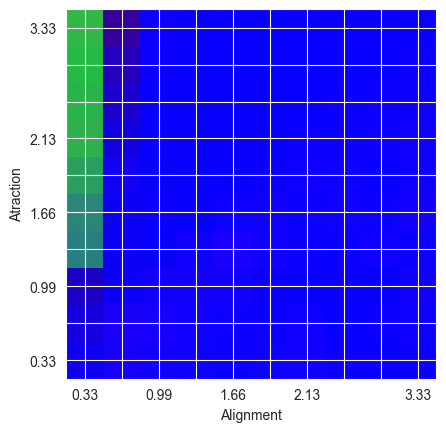

In [21]:
image=np.zeros((10,10,3))
image[:,:,2]=np.mean(Phase_Map_Metric[:,:,:,0],axis=2)
image[:,:,0]=np.mean(Phase_Map_Metric[:,:,:,1],axis=2)
for i in range(len(image)):
    for j in range(len(image)):
        if image[i,j,0]+image[i,j,2]<0.7:
            image[i,j,1]=1-np.max([image[i,j,0],image[i,j,2]])
fig, ax = plt.subplots(1,1)
ax.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
ax.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
xticks = [''] * len(Phase_Map_Metric[:,j,0,0])
xticks[0] = 0.33
xticks[int(len(xticks) / 4)] = 0.99
xticks[2 * int(len(xticks) / 4)] = 1.66
xticks[3 * int(len(xticks) / 4)] = 2.13
xticks[-1] = 3.33
ax.set_xticklabels(xticks)
yticks = [''] * len(Phase_Map_Metric[i,:,1,0])
yticks[0] = 0.33
yticks[int(len(yticks) / 4)] = 0.99
yticks[2 * int(len(yticks) / 4)] = 1.66
yticks[3 * int(len(yticks) / 4)] = 2.13
yticks[-1] = 3.33
ax.set_xlabel('Alignment')
ax.set_ylabel('Atraction')
ax.set_yticklabels(yticks)
plt.imshow(image, origin='lower')

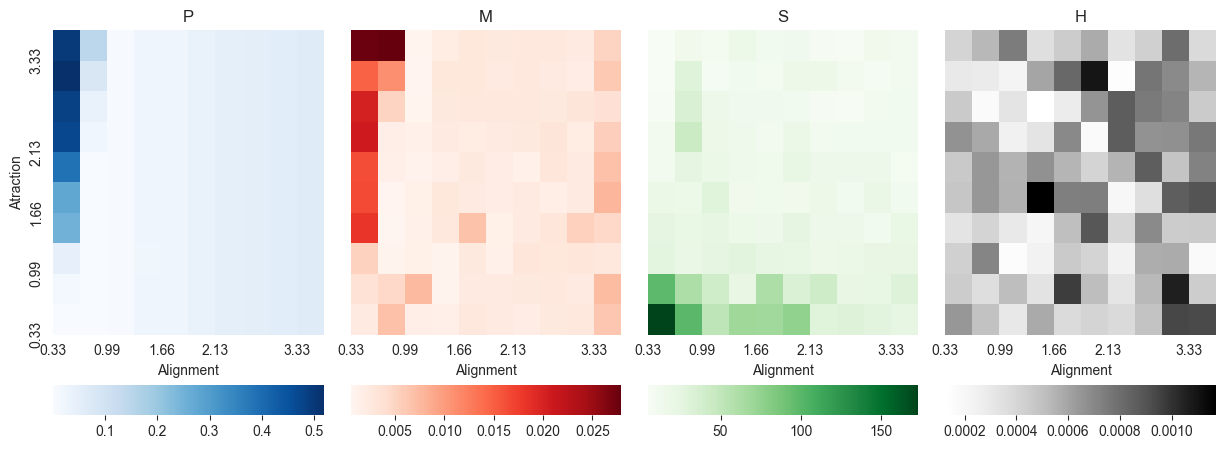

In [22]:
f,ax = plt.subplots(2,4,
            gridspec_kw={'height_ratios':[1,0.1]},figsize=(15,5))
f.subplots_adjust(hspace=0.3)
f.subplots_adjust(wspace=0.1)
values=np.mean(np.power(Phase_Map_Metric[:,:,:,0]-np.mean(Phase_Map_Metric[:,:,:,0],axis=2),2),axis=2)
g1 = sns.heatmap(values,cmap="Blues",cbar_ax=ax[1,0],ax=ax[0,0], cbar_kws={"orientation": "horizontal"})
g1.invert_yaxis()
g1.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g1.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g1.set_xticklabels(xticks)
g1.set_xlabel('Alignment')
g1.set_ylabel('Atraction')
g1.set_yticklabels(yticks)
g1.set_title("P")
values=np.mean(np.power(Phase_Map_Metric[:,:,:,1]-np.mean(Phase_Map_Metric[:,:,:,1],axis=2),2),axis=2)
g2 = sns.heatmap(values,cmap="Reds",cbar_ax=ax[1,1],ax=ax[0,1], cbar_kws={"orientation": "horizontal"})
g2.invert_yaxis()
g2.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g2.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g2.set_xticklabels(xticks)
g2.set_xlabel('Alignment')
g2.set_title("M")

values=np.mean(np.power((Phase_Map_Metric[:,:,:,2]-np.mean(Phase_Map_Metric[:,:,:,2]))/np.mean(Phase_Map_Metric[:,:,:,2],axis=2),2),axis=2)
g3 = sns.heatmap(np.max(Phase_Map_Metric[:,:,:,2],axis=2)-np.min(Phase_Map_Metric[:,:,:,2],axis=2),cmap="Greens",ax=ax[0,2], cbar_ax=ax[1,2], cbar_kws={"orientation": "horizontal"})
g3.invert_yaxis()
g3.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g3.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g3.set_xticklabels(xticks)
g3.set_xlabel('Alignment')
g3.set_title("S")
values=np.mean(np.power(Phase_Map_Metric[:,:,:,3]-np.mean(Phase_Map_Metric[:,:,:,3],axis=2),2),axis=2)
g4 = sns.heatmap(values,cmap="Greys",ax=ax[0,3], cbar_ax=ax[1,3], cbar_kws={"orientation": "horizontal"})
g4.invert_yaxis()
g4.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g4.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g4.set_xticklabels(xticks)
g4.set_xlabel('Alignment')
g4.set_title("H")
fig.suptitle("Metric Pseudo variance, no blind spot", y=1.0)
plt.show()

In [23]:
f,ax = plt.subplots(2,4,
            gridspec_kw={'height_ratios':[1,0.1]},figsize=(15,5))
f.subplots_adjust(hspace=0.3)
f.subplots_adjust(wspace=0.05)
values=np.mean(Phase_Map_Metric[:,:,:,0],axis=2)
g1 = sns.heatmap(values,cmap="Blues",cbar_ax=ax[1,0],ax=ax[0,0], cbar_kws={"orientation": "horizontal"})
g1.invert_yaxis()
g1.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g1.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g1.set_xticklabels(xticks)
g1.set_xlabel('Alignment')
g1.set_ylabel('Atraction')
g1.set_yticklabels(yticks)
g1.set_title("P")
values=np.mean(Phase_Map_Metric[:,:,:,1],axis=2)
g2 = sns.heatmap(values,cmap="Reds",cbar_ax=ax[1,1],ax=ax[0,1], cbar_kws={"orientation": "horizontal"})
g2.invert_yaxis()
g2.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g2.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g2.set_xticklabels(xticks)
g2.set_xlabel('Alignment')
g2.set_title("M")

values=np.log(np.mean(Phase_Map_Metric[:,:,:,2],axis=2))
g3 = sns.heatmap(np.max(Phase_Map_Metric[:,:,:,2],axis=2)-np.min(Phase_Map_Metric[:,:,:,2],axis=2),cmap="Greens",ax=ax[0,2], cbar_ax=ax[1,2], cbar_kws={"orientation": "horizontal"})
g3.invert_yaxis()
g3.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g3.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g3.set_xticklabels(xticks)
g3.set_xlabel('Alignment')
g3.set_title("S")
values=np.mean(Phase_Map_Metric[:,:,:,3],axis=2)
g4 = sns.heatmap(values,cmap="Greys",ax=ax[0,3], cbar_ax=ax[1,3], cbar_kws={"orientation": "horizontal"})
g4.invert_yaxis()
g4.set_yticks(range(len(Phase_Map_Metric[i,j,:,0])))
g4.set_xticks(range(len(Phase_Map_Metric[i,j,:,0])))
g4.set_xticklabels(xticks)
g4.set_xlabel('Alignment')
g4.set_title("H")
fig.suptitle("Metric Pseudo variance, no blind spot", y=1.0)
plt.show()